# Geospatial Data Analysis
## Excercise 5.2

In [25]:
import numpy as np
import os
import matplotlib.pyplot as plt
import collections

### Input features import and reshaping

In [26]:
X = np.load(os.path.join("data", "partB", "indianpinearray.npy"))
print("Initial shape: ", X.shape)
X = X.reshape(-1,200)
print("Final shape: ", X.shape)

Initial shape:  (145, 145, 200)
Final shape:  (21025, 200)


### Ground truth import and reshaping

In [27]:
y = np.load(os.path.join("data", "partB", "IPgt.npy"))
print("Initial shape: ", y.shape)
y = y.reshape(-1)
print("Final shape: ", y.shape)
print("Classes: ", np.unique(y))

Initial shape:  (145, 145)
Final shape:  (21025,)
Classes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


There is also class 0 in the dataset. I remove class 0 which corresponds to unlabeled data.

Final shapes:  (10249, 200) (10249,)
Classes:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Frequencies:  [46, 1428, 830, 237, 483, 730, 28, 478, 20, 972, 2455, 593, 205, 1265, 386, 93]


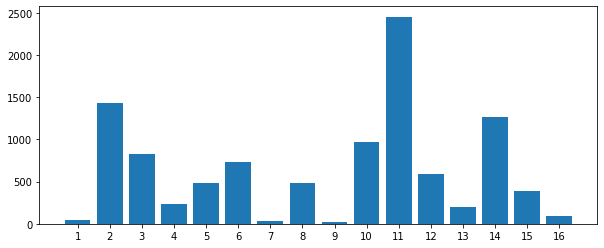

<module 'matplotlib.pyplot' from 'C:\\Users\\spele\\Miniconda3\\envs\\pytorch\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [74]:
X = X[y!=0]
y = y[y!=0]
print("Final shapes: ", X.shape, y.shape)
print("Classes: ", np.unique(y))
def hist(y):
    freq = [list(y).count(i) for i in np.unique(y)]
    print("Frequencies: ", freq)
    plt.bar(np.unique(y), height=freq)
    plt.xticks(np.unique(y))
    plt.show()
    return plt
hist(y)

### Imports

In [38]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

### Train/ Validation/ Test split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69, stratify=y)
print('Training set shape      : ', X_train.shape)
print('Training labels shape   : ', y_train.shape)
print('Test set shape          : ', X_test.shape)

Training set shape      :  (7174, 200)
Training labels shape   :  (7174,)
Test set shape          :  (3075, 200)


### Normalisation

I normalise X inside [0,1]. I need to apply separate normalisation to the training and test sets in order for the training process to be fair

In [7]:
sc = preprocessing.MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
print(X_train[:32])
print(y_train[:32])

[[0.46617916 0.40563682 0.15374732 ... 0.2244898  0.37096774 0.46938776]
 [0.1182206  0.44987513 0.12376874 ... 0.16326531 0.30645161 0.40816327]
 [0.35892748 0.40242597 0.11563169 ... 0.21428571 0.29032258 0.3877551 ]
 ...
 [0.69530774 0.63432037 0.39743041 ... 0.70408163 0.83870968 0.7755102 ]
 [0.11395491 0.40456654 0.15802998 ... 0.14285714 0.37096774 0.59183673]
 [0.09506399 0.31145202 0.15460385 ... 0.25510204 0.51612903 0.28571429]]
[14  6 14  3 14 14  2  3  3  3  2 11 14 10  4  8 11 14  8 12 11 14 11 14
 11 11 14 15  1  2  6 14]


### Parameter tuning

At first we train the classifiers using the GridSearch algorithm so as to decide the best hyperparameter values based on accuracy. We try different hyperparameter values for both kernel SVM and RandomForest algorithms. I also split in training/ test set, equally balancing all classes and I use less samples for tuning given that especially the RF algorithm is really resource consuming. We also use stratified K-Fold in GridSearch so as to be sure that cross validation is performed with balanced splits using StratifiedKFold CV.

In [8]:
#Set the parameters of each model by cross-validation gridsearch
names = ["SVM", "RandomForest"]
algorithms = [SVC(), RandomForestClassifier(n_jobs=-1)]
tuned_parameters = [{'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto'], 'C': [10, 100, 1000]},
                    {'n_estimators': [200, 600], 'max_depth': [4, 10, None], 'min_samples_leaf': [1, 2, 5]}]

cv_scores = []
best_scores = []
params = []
kfolds = StratifiedKFold(3)
# Gridsearch loop for all classifiers
i=0
for (a, t_p) in list(zip(algorithms, tuned_parameters)):
    print("Tuning hyper-parameters, based on accuracy for: {}\nwith parameter choice:\n{}\n".format(names[i], t_p))
    clf = GridSearchCV(a, t_p, cv=kfolds.split(X_train, y_train), scoring = 'accuracy', n_jobs=-1)
    clf.fit(X_train, y_train)
    print("Mean performance of each parameter combination based on Cross Validation")
    performance = pd.DataFrame(clf.cv_results_['params'])
    performance["Score"] = clf.cv_results_['mean_test_score']
    print(performance)
    print("Best parameters combination:")
    print(clf.best_params_)
    print("\nThe scores are computed on the full evaluation set for the best combination of parameters")
    #evaluate and store scores of estimators of each category on test set
    score = clf.score(X_test, y_test)
    print("Test score:", score)
    print("============================\n")
    #store round scores
    cv_scores.append(clf.cv_results_["mean_test_score"])
    params.append(clf.best_params_)
    best_scores.append(score)
    i+=1
final_scores = dict(zip(names, best_scores))
print("Test set performances:")
print(final_scores)

Tuning hyper-parameters, based on accuracy for: SVM
with parameter choice:
{'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto'], 'C': [10, 100, 1000]}

Mean performance of each parameter combination based on Cross Validation
       C  gamma  kernel     Score
0     10  scale     rbf  0.859909
1     10  scale  linear  0.856982
2     10   auto     rbf  0.605520
3     10   auto  linear  0.856982
4    100  scale     rbf  0.897266
5    100  scale  linear  0.849176
6    100   auto     rbf  0.818789
7    100   auto  linear  0.849176
8   1000  scale     rbf  0.895176
9   1000  scale  linear  0.833425
10  1000   auto     rbf  0.872037
11  1000   auto  linear  0.833425
Best parameters combination:
{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}

The scores are computed on the full evaluation set for the best combination of parameters
Test score: 0.9203252032520325

Tuning hyper-parameters, based on accuracy for: RandomForest
with parameter choice:
{'n_estimators': [200, 600], 'max_depth': [4, 1

## Pytorch

### Imports

In [41]:
# =============================================================================
# Imports
# =============================================================================
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset
#from training import trainNN

### Dataset function to be used by the dataloader 

I implement a dataset function that its main purpose is to feed the models with batches of data. In larger datasets this function can be used to read data straight from the disk by providing list of indices  to the feats and labels variables instead of the actual features and performing the access to the disk inside the _ _ getitem _ _ method. This is more kind of a simulation of this process.

In [42]:
class IndianPineArray(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = np.array(y).astype('int64')
        
    def __getitem__(self, index):
        #features = np.load("indianpinearray")
        return {'bands': self.X[index], 'labels': self.y[index]}
    
    def __len__(self):
        return len(self.X)

### Train/ Test split & Normalisation

I split again but this time I also use a valitation set because this time I am not going to use GridSearchCV that splits automatically the training set in smaller training and validation sets and applies Cross Validation Such a process proves to be extremely resource consuming for a neural network. For that reason we limit out study to one specific train and validation split. As far as the test set is concerned we don't use it at all during the training process in order to decide the hyperparameter values (learning rate, NN architecture, number of epochs to apply early stopping and stop training). We only use it for evaluation purposes at the end, as if it was generated after the training process which is like simulating a real world problem.

Training set shape      :  (7174, 200)
Training labels shape   :  (7174,)
Validation set shape    :  (3075, 200)
Validation labels shape :  (3075,)
Frequencies:  [32, 1000, 581, 166, 338, 511, 20, 335, 14, 680, 1718, 415, 144, 885, 270, 65]


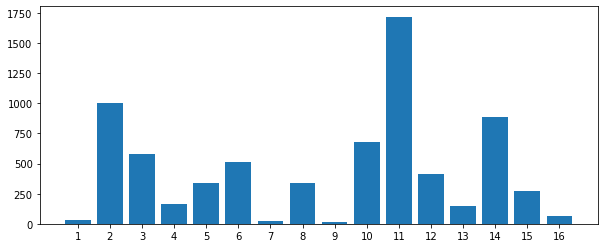

Frequencies:  [14, 428, 249, 71, 145, 219, 8, 143, 6, 292, 737, 178, 61, 380, 116, 28]


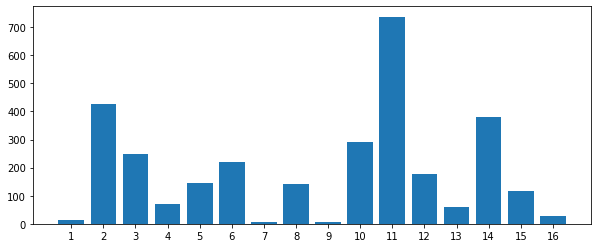

<module 'matplotlib.pyplot' from 'C:\\Users\\spele\\Miniconda3\\envs\\pytorch\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [81]:
# Split to training and test set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=69, stratify=y)

# Normalisation
sc = preprocessing.MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.fit_transform(X_val)

# Split training set to training and validation set
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=69, stratify=y_train)
print('Training set shape      : ', X_train.shape)
print('Training labels shape   : ', y_train.shape)
print('Validation set shape    : ', X_val.shape)
print('Validation labels shape : ', y_val.shape)
#print('Test set shape          : ', X_test.shape)
hist(y_train)
hist(y_val)

### Dataloader

In [82]:
train = IndianPineArray(X_train, y_train)
val = IndianPineArray(X_val, y_val)
#test = IndianPineArray(X_test, y_test)

trainloader = DataLoader(train, batch_size=128, num_workers=0)
valloader = DataLoader(val, batch_size=128, num_workers=0)
#testloader = DataLoader(test, batch_size=32, num_workers=0)

This is an example of a data batch as fetched by the dataloader of the dataloader

In [83]:
list(enumerate(trainloader))[0]

(0, {'bands': tensor([[0.4662, 0.4056, 0.1537,  ..., 0.2245, 0.3710, 0.4694],
          [0.1182, 0.4499, 0.1238,  ..., 0.1633, 0.3065, 0.4082],
          [0.3589, 0.4024, 0.1156,  ..., 0.2143, 0.2903, 0.3878],
          ...,
          [0.6831, 0.7328, 0.6493,  ..., 0.5102, 0.4032, 0.4898],
          [0.0268, 0.5847, 0.2441,  ..., 0.6531, 0.6129, 0.5918],
          [0.0165, 0.5872, 0.3310,  ..., 0.7959, 0.6129, 0.5714]],
         dtype=torch.float64),
  'labels': tensor([14,  6, 14,  3, 14, 14,  2,  3,  3,  3,  2, 11, 14, 10,  4,  8, 11, 14,
           8, 12, 11, 14, 11, 14, 11, 11, 14, 15,  1,  2,  6, 14,  8, 12, 11, 16,
          10, 11, 11, 11, 11, 10,  6, 11,  6, 11,  8, 10,  6,  3, 14,  2, 12, 15,
          16, 15,  3, 14,  3,  2,  3, 11, 11, 14,  5, 14, 10, 10,  2, 11,  2, 13,
           2,  2, 11,  5,  5, 10,  6, 14, 12, 11, 14,  3, 11,  2, 13,  8,  2,  3,
          11, 11,  2, 11,  3, 11, 11,  5, 11, 11, 15, 11,  2, 12,  6, 14,  3,  2,
           5, 15,  3, 13, 11,  2,  6, 14,  

### Multilayer Perceptron Architectures

In [97]:
import torch.nn as nn
import torch.nn.functional as F

class MLP1(nn.Module):
    def __init__(self):
        super(MLP1, self).__init__()
        self.fc1 = nn.Linear(200, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 16)
         
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        logits = self.fc4(x)
        return logits

class MLP2(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.layers = nn.Sequential(
            nn.Linear(self.input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, self.output_dim)
        )
         
    def forward(self, x):
        logits = self.layers(x.float())
        return logits

I also check if gpu is available in order to process the tensors in the appropriate device

In [98]:
# =============================================================================
# Cuda
# =============================================================================
cuda = torch.cuda.is_available()
torch.cuda.empty_cache()
if cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


### Training and validation process of the models
In this section I instantiate the models, I choose loss function (Cross Entropy Loss) and the optimizer (Adam)
I also train the NNs. I also use the validation set in order to locate the appropriate number of epochs that prevents overfitting.

In [101]:
import numpy as np
import torch
from sklearn import metrics
import os
import matplotlib.pyplot as plt

def logit_accuracy(logits, y_true):
    max_vals, max_indices = torch.max(logits, 1)
    acc = (max_indices == y_true).sum().item()/max_indices.size()[0]
    return acc, y_true, max_indices

def trainNN (model, patience, best_model_name, epochs, trainloader, valloader, device,
             optimizer, criterion):
    # Initialisations
    epoch = 0
    epoch_loss_val = []
    epoch_loss_train = []
    countdown = patience    

    # Training
    while epoch < epochs and countdown > 0:
        # Training
        epoch +=1
        batch_loss = []
        y_pred = []
        batch_acc = []
        # enumerate fetches a batch of the data for training!
        for i, data in enumerate(trainloader):
            inputs = data['bands'].to(device)
            labels = data['labels'].long().to(device)
            # reset gradients for each batch
            optimizer.zero_grad()
            # forward step
            out = model(inputs.float())
            # compute loss and save it to list
            loss = criterion(out, labels)
            batch_loss.append(loss.item())
            # backpropagate the loss
            loss.backward()
            # update weights according to the selected optimizer
            optimizer.step()
            # calculate batch accuracy for this epoch
            batch_acc.append(logit_accuracy(out, labels)[0])
        print("Epoch: {}:\nTraining loss  : {:.5f}, Training accuracy  : {:.3f}".
            format(epoch, np.mean(batch_loss), np.mean(batch_acc)))
        epoch_loss_train.append(np.mean(batch_loss))
        # Validation
        batch_loss_val = []
        batch_acc_val = []
        y_pred_val = []
        
        # Validation
        # no need to store gradients here (Validation purposes only)
        with torch.no_grad():
            for i, data in enumerate(valloader):
                inputs_val = data['bands'].to(device)
                labels_val = data['labels'].long().to(device)
                out_val = model(inputs_val.float())
                loss_val = criterion(out_val, labels_val)
                batch_loss_val.append(loss_val.item())
                # calculate batch accuracy for this epoch
                batch_acc_val.append(logit_accuracy(out_val, labels_val)[0])
        epoch_loss_val.append(np.mean(batch_loss_val))
        print("Validation loss: {:1.3f}, Validation accuracy: {:1.3f}\nCountdown: {} \n".
              format(epoch_loss_val[-1], np.mean(batch_acc_val), countdown))
        # Early stopping condtion: N epochs without achieving loss less than the
        # present minimum. No need to save models before patience
        if epoch_loss_val[-1] <= min(epoch_loss_val):
            countdown = patience #start countdown
        #checkpoint 
            if epoch >= patience: # no need to save before that
        #I ovewrite models so as to keep the last to trigger the countdown
                torch.save(model, os.path.join(os.getcwd(),
                        "models" + os.path.sep + best_model_name + ".pt"))
        else:
            countdown -= 1
    print("Finished Training!")
    # Plot Train / Validation Loss

    plt.rcParams["figure.figsize"] = (10,4)
    plt.figure()
    plt.title("Relative Loss")
    plt.plot(list(range(1,epoch+1)), epoch_loss_train, label='Training set')
    plt.plot(list(range(1,epoch+1)), epoch_loss_val,  label='Validation set')
    plt.grid()
    plt.ylim(0, 3)
    plt.legend(fancybox=True)
    plt.show()
    return epoch_loss_train, epoch_loss_val, epoch

**Model 1**

In [ ]:
# Patience is the number of epochs that we have to wait for no
# loss decrease in the validation set to apply early stopping
# instead of waitng till the end of epochs (999)
lr = 0.01
patience = 500 
epochs = 999

# Instantiate model
nn1 = MLP1().to(device)
print(nn1)
# Set loss and optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(nn1.parameters(), lr=lr)
# training
_, _, _ = trainNN(model=nn1, patience=patience, best_model_name="MLP1",
                epochs=epochs, trainloader=trainloader, valloader=valloader, 
                device=device, optimizer=optimizer, criterion=criterion)

MLP1(
  (fc1): Linear(in_features=200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=16, bias=True)
)
Epoch: 1:
Training loss  : 1.70387, Training accuracy  : 0.399
Validation loss: 1.798, Validation accuracy: 0.422
Countdown: 500 

Epoch: 2:
Training loss  : 1.44300, Training accuracy  : 0.467
Validation loss: 1.587, Validation accuracy: 0.468
Countdown: 500 

Epoch: 3:
Training loss  : 1.39497, Training accuracy  : 0.477
Validation loss: 1.615, Validation accuracy: 0.466
Countdown: 500 

Epoch: 4:
Training loss  : 1.36347, Training accuracy  : 0.491
Validation loss: 1.488, Validation accuracy: 0.503
Countdown: 499 

Epoch: 5:
Training loss  : 1.31689, Training accuracy  : 0.513
Validation loss: 1.572, Validation accuracy: 0.493
Countdown: 500 

Epoch: 6:
Training loss  : 1.30839, Training accuracy  : 0.520
Validation loss: 1.591, Val

**Model 2**

MLP2(
  (layers): Sequential(
    (0): Linear(in_features=200, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=256, bias=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): ReLU()
    (14): Linear(in_features=128, out_features=16, bias=True)
  )
)
Epoch: 1:
Training loss  : 2.74194, Training accuracy  : 0.070
Validation loss: 2.737, Validation accuracy: 0.068
Countdown: 50 

Epoch: 2:
Training loss  : 2.72748, Training accuracy  : 0.206
Validation loss: 2.709, Validation accuracy: 0.260
Countdown: 50 

Epoch: 3:
Training loss  : 2.64833, Training accuracy  : 0.236
Validation loss: 2.489, V

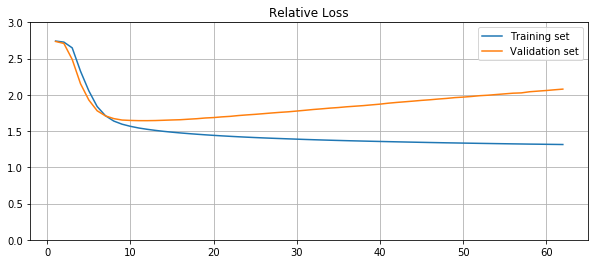

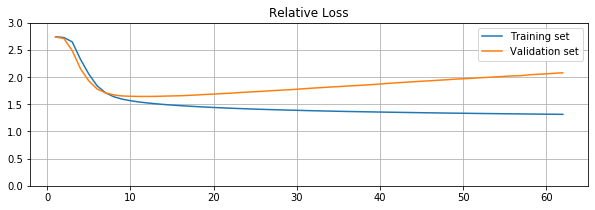

In [91]:
lr = 1e-5
patience = 50 # initialise here
epochs = 999

# Instantiate model
nn2 = MLP2(input_dim=X_train.shape[1], output_dim=16).to(device)
print(nn2)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(nn2.parameters(), lr=lr)

# training
epoch_loss_train, epoch_loss_val, epoch = trainNN(model=nn2, patience=patience, best_model_name="MLP2",
                                           epochs=epochs, trainloader=trainloader, valloader=valloader, 
                                           device=device, optimizer=optimizer, criterion=criterion)

# Plot Train / Validation Loss

plt.rcParams["figure.figsize"] = (10,3)
plt.figure()
plt.title("Relative Loss")
plt.plot(list(range(1,epoch+1)), epoch_loss_train, label='Training set')
plt.plot(list(range(1,epoch+1)), epoch_loss_val,  label='Validation set')
plt.grid()
plt.ylim(0, 3)
plt.legend(fancybox=True)
plt.show()

In [ ]:
# =============================================================================
# Load Best model 
# =============================================================================
# Select model file name between specific list of prerun models (Models folder)
stored_models = ["simple", "Bi", "BiDr", "BiDrRe", "BiDrRe_packed"]
best_model_name = stored_models[0]

# I load the appropriate model
model = torch.load(os.path.join(os.getcwd(),
                   "models"+os.path.sep+best_model_name+".pt"))
# To set dropout and batch normalization layers to evaluation mode 
model.eval() 

In [ ]:
# =============================================================================
# Best Model on validation set
# =============================================================================
y_pred_val = []
y_val = [] # I reconstruct it in the right order
batch_loss = []
batch_acc = []

with torch.no_grad():
    for i, data in enumerate(valloader):
        inputs_val = data['bands'].to(device) 
        labels_val = data['labels'].to(device)
        batch_pred = model(inputs_val)
        loss = criterion(batch_pred, labels_val)
        batch_loss.append(loss.item())
        batch_pred = [np.argmax(batch_pred[i].
                            to(torch.device('cpu')).
                            detach().numpy()) for i in range(len(batch_pred))]
        y_pred_val.append(batch_pred)
        y_val.append(data['labels'])
        batch_acc.append(metrics.
                         accuracy_score(labels_val.
                                        to(torch.device('cpu')).
                                        detach().numpy(), batch_pred))
    print("Validation loss: {:1.3f}, Validation Acc: {:1.3f} \n".
          format(np.mean(batch_loss), np.mean(batch_acc)))
# Predicted labels to numpy array
y_pred_val = np.concatenate([y_pred_val[i] 
                             for i in range(len(y_pred_val))]).reshape(-1)
y_val = np.concatenate([y_val[i] for i in range(len(y_val))]).reshape(-1)
# =============================================================================
# Confusion Matrix Validation Set
# =============================================================================
# Validation
labels = list(set(y_val))
print(classification_report(y_val, y_pred_val))
cnf_mat = confusion_matrix(y_val, y_pred_val, 
                           labels=list(range(num_classes)))
print("\n")
plt.figure()
plot_confusion_matrix(cnf_mat, classes=labels, 
                      title='Confusion matrix of validation set')

### Final evaluation

In [ ]:
###############################################################################
# Evaluation with various classification metrics (classification report)
###############################################################################
from confusion_matrix import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69, stratify=y)

models = {'kNN': KNeighborsClassifier(n_neighbors=3),
          'NB': GaussianNB(),
          'MLP1':
          'MLP2':  }
# Create scores dictionary for each algorithm
scores=[]
mdl=[]
results=[]
for model in models.keys():
    clf = models[model]
    clf.fit(X_train,  y_train)
    mdl.append(model)
    y_pred = clf.predict(X_test)
    results.append((clf.score(X_test, y_test), y_pred))
    print (model, "\n")
    print(metrics.classification_report(y_test, y_pred, digits=5))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    plot_confusion_matrix(cm, classes=[0,1], title=model, cmap=plt.cm.Greens)
    print("True Positives: {}, False Positives: {}, True Negatives:, False Negatives: {} \n\n".format(cm[0,0], cm[0,1], cm[1,1], cm[1,0]))

In [ ]:
###############################################################################
# Evaluation with various classification metrics (classification report)
###############################################################################
from confusion_matrix import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

N=1000
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69, stratify=y)
X_train, X_test, y_train, y_test = X_train[:N,:], X_test[:N,:], y_train[:N], y_test[:N]

models = {'kNN': KNeighborsClassifier(n_neighbors=3),
          'NB': GaussianNB(),
          'Perceptron': Perceptron(penalty='l1')}
# Create scores dictionary for each algorithm
scores=[]
mdl=[]
results=[]
for model in models.keys():
    clf = models[model]
    clf.fit(X_train,  y_train)
    mdl.append(model)
    y_pred = clf.predict(X_test)
    results.append((clf.score(X_test, y_test), y_pred))
    print (model, "\n")
    print(metrics.classification_report(y_test, y_pred, digits=5))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    plot_confusion_matrix(cm, classes=[0,1], title=model, cmap=plt.cm.Greens)
    print("True Positives: {}, False Positives: {}, True Negatives:, False Negatives: {} \n\n".format(cm[0,0], cm[0,1], cm[1,1], cm[1,0]))